## Model: winning %
### features: win-lose % + simulated data from cosine similarity
#### cosine similarity was used to suppliment data from battle logs by identifying pokemon that are most similar to pokemon that appear in the battle

### Load CSV file
#### Import necessary libraries

In [2]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score


#### Load in dataset file

In [3]:
training02_data = pd.read_csv("../data/trainingdata02_stats_type.csv")

# print column names
#for col in training02_df.columns:
    #print(col)

training02_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100024 entries, 0 to 100023
Columns: 174 entries, battle_id to p2b_Water
dtypes: float64(1), int64(112), object(61)
memory usage: 132.8+ MB


#### filter out ties and short battles

In [4]:
# drop battles that end in a tie
# filter out battles less than 5 turns
training02_df = training02_data.copy()

training02_df = training02_df.drop(training02_df[training02_df['win'] == 0].index)
training02_df = training02_df[training02_df['total_turn'] >= 5]

In [5]:
training02_df

,battle_id,turn,total_turn,rank,weather,field,condition,p1_side,p1a_form,p1a_hp,...,p2b_Ghost,p2b_Grass,p2b_Ground,p2b_Ice,p2b_Normal,p2b_Poison,p2b_Psychic,p2b_Rock,p2b_Steel,p2b_Water
0,2099996083,0,5,1643.5,NaN,Psychic Terrain:5,NaN,NaN,Smeargle,100,...,0,0,0,0,0,0,0,0,0,0
1,2099996083,1,5,1643.5,NaN,Psychic Terrain:4,Trick Room:4,NaN,Smeargle,1,...,0,0,0,0,0,0,0,0,0,0
2,2099996083,2,5,1643.5,SunnyDay:5,Psychic Terrain:3,Trick Room:3,NaN,Torkoal,100,...,0,0,0,0,0,0,0,0,0,0
3,2099996083,3,5,1643.5,SunnyDay:4,Psychic Terrain:2,Trick Room:2,NaN,Torkoal,100,...,0,0,0,0,0,0,0,0,0,0
4,2099996083,4,5,1643.5,SunnyDay:3,Psychic Terrain:1,Trick Room:1,NaN,Torkoal,55,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100012,2127998319,1,5,1418.5,NaN,Electric Terrain:4,NaN,NaN,Iron Bundle,1,...,0,0,0,0,0,0,0,0,0,0
100013,2127998319,2,5,1418.5,NaN,Electric Terrain:3,NaN,NaN,Iron Bundle,1,...,0,0,0,0,0,0,0,0,0,0
100014,2127998319,3,5,1418.5,NaN,Electric Terrain:2,NaN,NaN,Iron Bundle,1,...,0,0,0,0,0,0,0,0,0,0
100015,2127998319,4,5,1418.5,NaN,Electric Terrain:1,NaN,NaN,Miraidon,100,...,0,0,0,0,0,0,0,0,0,0


#### Keep only the last turn: one row per battle

In [6]:
# Keep last turn of battle
training02_df = training02_df[training02_df["turn"]+1 == training02_df["total_turn"]]


#### Make train-test split

In [7]:
train, test = train_test_split(training02_df,
                               test_size = 0.2,
                               random_state = 151)

#### `training02_df` is now just the training data set 

In [8]:
training02_df_train = train.copy()

In [9]:
training02_df_train

,battle_id,turn,total_turn,rank,weather,field,condition,p1_side,p1a_form,p1a_hp,...,p2b_Ghost,p2b_Grass,p2b_Ground,p2b_Ice,p2b_Normal,p2b_Poison,p2b_Psychic,p2b_Rock,p2b_Steel,p2b_Water
38339,2123655091,4,5,1168.0,Sandstorm:1,Psychic Terrain:1,NaN,NaN,Excadrill,91,...,0,0,0,0,1,0,1,0,0,0
22422,2114908379,6,7,1683.5,NaN,Grassy Terrain:3,NaN,NaN,Ho-Oh,72,...,0,0,0,0,0,0,0,0,1,0
37862,2123645316,4,5,1292.5,SunnyDay:1,NaN,NaN,NaN,Sneasler,100,...,0,0,0,0,0,0,0,0,0,0
65700,2124550456,9,10,1000.0,NaN,Grassy Terrain:3,NaN,NaN,Amoonguss,84,...,0,1,0,0,0,0,0,0,0,0
36855,2123629599,4,5,1393.5,NaN,NaN,NaN,NaN,Terapagos-Terastal,86,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36674,2123626756,5,6,1331.0,SunnyDay:3,NaN,NaN,NaN,Koraidon,100,...,0,0,1,0,0,0,0,0,0,0
77520,2127172806,5,6,1334.5,Snow:2,NaN,NaN,NaN,Glastrier,100,...,0,0,0,0,0,0,0,0,0,0
48655,2124016758,6,7,1020.0,NaN,NaN,NaN,NaN,Entei,46,...,0,0,0,0,0,0,0,0,0,0
80410,2127231944,5,6,1449.0,NaN,NaN,NaN,NaN,Archaludon,100,...,0,0,1,0,0,0,0,0,0,0


#### Get match-up for each pokemon

In [10]:
# select battle_id, win, and all pokemon_form columns
# convert to long df with each pokemon match-up pair

training02_df_train = training02_df_train[['battle_id', 'win',
                               'p1a_form', 'p1b_form', 'p1c_form', 'p1d_form',
                               'p2a_form', 'p2b_form', 'p2c_form', 'p2d_form']]

training02_df_long = pd.melt(training02_df_train, id_vars = ["battle_id", "win", 'p2a_form', 'p2b_form', 'p2c_form', 'p2d_form'],
                             var_name = 'p1', value_name = "player1_mons")

training02_df_long = pd.melt(training02_df_long, id_vars=["battle_id", "win", 'p1', 'player1_mons'],
                             var_name="p2", value_name="player2_mons")

training02_df_long = training02_df_long.drop(['p1','p2'], axis=1)
training02_df_long = training02_df_long.drop_duplicates()
training02_df_long = training02_df_long.sort_values("battle_id")
training02_df_long = training02_df_long.drop(training02_df_long[training02_df_long['player1_mons'] == 'unknown'].index)
training02_df_long = training02_df_long.drop(training02_df_long[training02_df_long['player2_mons'] == 'unknown'].index)
training02_df_long.head(10)

,battle_id,win,player1_mons,player2_mons
107482,2099996083,-1,Calyrex-Ice,Urshifu
68202,2099996083,-1,Torkoal,Indeedee-F
52490,2099996083,-1,Smeargle,Calyrex-Ice
5354,2099996083,-1,Torkoal,Torkoal
13210,2099996083,-1,Calyrex-Ice,Torkoal
99626,2099996083,-1,Torkoal,Urshifu
76058,2099996083,-1,Calyrex-Ice,Indeedee-F
44634,2099996083,-1,Calyrex-Ice,Calyrex-Ice
115338,2099996083,-1,Smeargle,Urshifu
83914,2099996083,-1,Smeargle,Indeedee-F


#### separate Pokemon into winners vs losers

In [11]:
training02_df_long["winning_mon"] = training02_df_long.apply(lambda x: x["player1_mons"] if x["win"]== 1 else x["player2_mons"], axis=1)
training02_df_long["losing_mon"] = training02_df_long.apply(lambda x: x["player1_mons"] if x["win"]== -1 else x["player2_mons"], axis=1)

training02_df_long = training02_df_long.drop(['player1_mons','player2_mons', 'win'], axis=1)

training02_df_long = training02_df_long.groupby(['winning_mon', 'losing_mon']).size().reset_index()
training02_df_long.columns = ['winning_mon', 'losing_mon', 'win_count']
training02_df_long

,winning_mon,losing_mon,win_count
0,Abomasnow,Alomomola,1
1,Abomasnow,Amoonguss,2
2,Abomasnow,Archaludon,1
3,Abomasnow,Calyrex-Ice,3
4,Abomasnow,Calyrex-Shadow,2
...,...,...,...
22846,Zekrom,Rayquaza,1
22847,Zekrom,Rhyperior,1
22848,Zekrom,Ursaluna-Bloodmoon,1
22849,Zekrom,Urshifu-Rapid-Strike,4


#### Count number of match-ups and determine winning percentage

In [12]:
training02_df_long_wl = training02_df_long.copy()

training02_df_long_wl_flip = training02_df_long_wl.copy()
training02_df_long_wl_flip.columns = ['losing_mon', 'winning_mon', 'lose_count']
training02_df_long_wl = training02_df_long_wl.merge(training02_df_long_wl_flip, how = "outer")
training02_df_long_wl = training02_df_long_wl.fillna(0)
training02_df_long_wl["win_percentage"] = (training02_df_long_wl["win_count"])/(training02_df_long_wl["win_count"] + training02_df_long_wl["lose_count"])

training02_df_long_wl

,winning_mon,losing_mon,win_count,lose_count,win_percentage
0,Abomasnow,Alomomola,1.0,0.0,1.000000
1,Abomasnow,Amoonguss,2.0,1.0,0.666667
2,Abomasnow,Archaludon,1.0,0.0,1.000000
3,Abomasnow,Calyrex-Ice,3.0,5.0,0.375000
4,Abomasnow,Calyrex-Shadow,2.0,3.0,0.400000
...,...,...,...,...,...
32109,Zekrom,Whimsicott,1.0,1.0,0.500000
32110,Zekrom,Zacian-Crowned,0.0,1.0,0.000000
32111,Zweilous,Iron Hands,0.0,1.0,0.000000
32112,Zweilous,Miraidon,0.0,1.0,0.000000


### What pokemon are the best counters for a given oppoonent pokemon?

#### return top 3 pokemon with the best win percentage

In [13]:
# randomly generate an opponent pokemon
pokemon = list(training02_df_long_wl["winning_mon"].unique())
choose = str(random.sample(pokemon, 1)[0])

print("My opponent will play:", choose)

# find top 3 counters
best_options = training02_df_long_wl[training02_df_long_wl["losing_mon"] == choose]
best_options = best_options[best_options["win_percentage"] > 0.5]
best_options = best_options.sort_values(["win_percentage", "win_count"], ascending=False)
best_options = list(best_options["winning_mon"].head(3))

print("My best options are:", ", ".join(best_options))


My opponent will play: Thwackey
My best options are: Annihilape, Flutter Mane, Ogerpon-Hearthflame-Tera


### Create cosine similarity matrix

In [14]:
poke = pd.read_csv("../data/pokedex_ohe.csv")

poke.index = poke["Name"]
poke = poke.drop(["Name", "Pokedex_ID", "Total_Stats"], axis=1)

sc = StandardScaler()
poke[["HP", "Attack", "Defense", "SpAtk", "SpDef", "Speed"]] = sc.fit_transform(poke[["HP", "Attack", "Defense", "SpAtk", "SpDef", "Speed"]])

poke_cosine = pd.DataFrame(cosine_similarity(poke))

poke_cosine.index = poke.index
poke_cosine.columns = poke.index

def get_similar_mons(mon, cosines):
    mons = list(cosines[mon].sort_values(ascending=False).head(11).index)[1:3]
    return mons


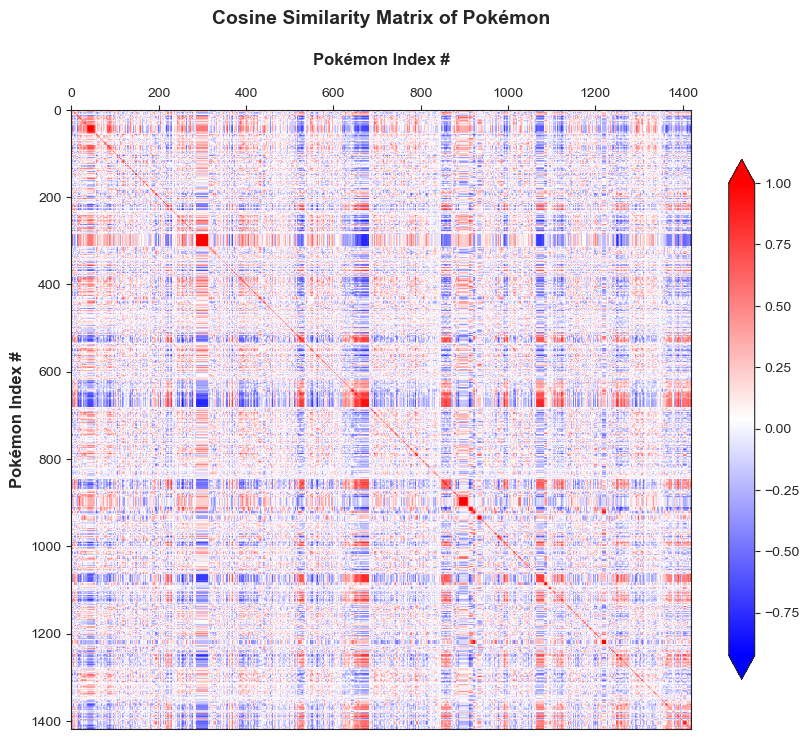

In [15]:
#cosine similarity matrix of scaled stats + ohe types for all pokemon:

sns.set_style("white")

fig, ax = plt.subplots(figsize = (8,8), layout = 'constrained')
plt.imshow(poke_cosine, cmap = 'bwr')
plt.colorbar(extend='both', shrink = 0.7, orientation = 'vertical')

plt.ylabel("Pokémon Index #", fontsize = 12, weight = "bold")
plt.xlabel("Pokémon Index #\n", fontsize = 12, weight = "bold")
ax.tick_params(top = True, labeltop = True, left = True, bottom = False, labelbottom = False)
ax.xaxis.set_label_position('top') 

plt.title('Cosine Similarity Matrix of Pokémon\n', fontsize = 14, weight = "bold")

plt.savefig('Cosine_Similarity_Matrix.png', bbox_inches = 'tight')

plt.show()


#### (Demo below)

In [16]:
team1 = list(random.sample(pokemon, 4)[0:4])
team2 = list(random.sample(pokemon, 4)[0:4])

team1_expanded = []
team2_expanded = []

In [17]:
## Here we add cosine similar mons

for mon in team1:
    team1_expanded.append(mon)
    for similar_mon in get_similar_mons(mon, poke_cosine):
        team1_expanded.append(similar_mon)

for mon in team2:
    team2_expanded.append(mon)
    for similar_mon in get_similar_mons(mon, poke_cosine):
        team2_expanded.append(similar_mon)

In [18]:
# Testing the code
print("Team 1: ", ", ".join(team1))
print("  VS")
print("Team 2: ", ", ".join(team2), "\n")

      
dataframe_list = []

for team1_member in team1_expanded:
    for team2_member in team2_expanded:
        tmp_df = training02_df_long_wl[training02_df_long_wl["winning_mon"] == team1_member]
        tmp_df = tmp_df[tmp_df["losing_mon"] == team2_member]

        if len(tmp_df) >= 1:
            dataframe_list.append(tmp_df.iloc[0])


match_ups_df = pd.DataFrame(dataframe_list)

if len(dataframe_list) > 0:
    confidence = sum(match_ups_df["win_count"])+sum(match_ups_df["lose_count"])
    overall_prob = sum(match_ups_df["win_count"])/confidence

    confidence_str = "-1"

    if (confidence < 5): confidence_str = "weak confidence!"
    elif (confidence < 15): confidence_str = "moderate confidence!"
    else: confidence_str = "much confidence!"

    print(f"Team 1 will win", round(100*overall_prob, 2),"% of the time and I have", confidence_str)

else:
    print("I don't have enough information on these matchups!")

match_ups_df.head(30)

Team 1:  Slowbro-Galar, Falinks, Tatsugiri-Droopy, Inteleon
  VS
Team 2:  Lumineon, Arboliva, Grovyle, Drifblim 

Team 1 will win 100.0 % of the time and I have weak confidence!


,winning_mon,losing_mon,win_count,lose_count,win_percentage
26237,Tatsugiri-Droopy,Porygon2,1.0,0.0,1.0
26237,Tatsugiri-Droopy,Porygon2,1.0,0.0,1.0


#### Testing win-lost on test set:

In [19]:
# Here we predict the battles in the test set
    # takes about 7 minutes to run on 2k battles

x_test = test[['p1a_form', 'p1b_form', 'p1c_form', 'p1d_form', 'p2a_form', 'p2b_form', 'p2c_form', 'p2d_form']]

y_actual = test["win"]
y_pred = []
y_probs = []
y_confidences = []

for index, row in x_test.iterrows():

    # remove `unknown` values
    team1_test = [i for i in list(row[0:4]) if i != "unknown"]
    team2_test = [i for i in list(row[4:8]) if i != "unknown"]

    # created expanded teams
    team1_test_expanded = []
    team2_test_expanded = []

    #fill in expanded teams with pokemon with high cosine similarity
    for mon in team1_test:
        team1_test_expanded.append(mon)
        for similar_mon in get_similar_mons(mon, poke_cosine):
            team1_test_expanded.append(similar_mon)

    for mon in team2_test:
        team2_test_expanded.append(mon)
        for similar_mon in get_similar_mons(mon, poke_cosine):
            team2_test_expanded.append(similar_mon)

    dataframe_list = []

    #check win-lost for each pokemon pair between player 1 and player 2
    for team1_member in team1_test_expanded:
        for team2_member in team2_test_expanded:
            tmp_df = training02_df_long_wl[training02_df_long_wl["winning_mon"] == team1_member]
            tmp_df = tmp_df[tmp_df["losing_mon"] == team2_member]

            if len(tmp_df) >= 1:
                dataframe_list.append(tmp_df.iloc[0])

    match_ups_df = pd.DataFrame(dataframe_list)

    # calculate win percentage
    if len(dataframe_list) > 0:
        confidence = sum(match_ups_df["win_count"])+sum(match_ups_df["lose_count"])
        overall_prob = sum(match_ups_df["win_count"])/confidence

        if (confidence < 5): 
            y_confidences.append("0")
        elif (confidence < 15): 
            y_confidences.append("1")
        else: 
            y_confidences.append("2")

        y_probs.append(overall_prob)

        if overall_prob > 0.5:
            y_pred.append(1)
        else:
            y_pred.append(-1)



In [20]:
accuracy_score(y_actual, y_pred)

0.5259674134419552

#### Check y predictions and y probabilities:

In [22]:
y_pred_list = [int(i) for i in y_pred]
    
# Printing modified list
print ("List of y_predictions: " + str(y_pred_list))

def minmax(val_list):
    min_val = min(val_list)
    max_val = max(val_list)

    return (min_val, max_val)

minmax(y_pred)

List of y_predictions: [1, -1, -1, -1, -1, 1, 1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1,

(-1, 1)

In [23]:
y_probs_list = [ '%.5f' % num for num in y_probs ]


# Printing modified list
print ("List of y_probabilities: ", y_probs_list)

def minmax(val_list):
    min_val = min(val_list)
    max_val = max(val_list)

    return (min_val, max_val)

minmax(y_probs_list)

List of y_probabilities:  ['0.51543', '0.49441', '0.46203', '0.49254', '0.49359', '0.53261', '0.52763', '0.48712', '0.53252', '0.50420', '0.50100', '0.51977', '0.46296', '0.49765', '0.49512', '0.48241', '0.48285', '0.51412', '0.50671', '0.48546', '0.48170', '0.46154', '0.51230', '0.49581', '0.45858', '0.44568', '0.51048', '0.52264', '0.48292', '0.50179', '0.52607', '0.46305', '0.52969', '0.47014', '0.50548', '0.51442', '0.46298', '0.50790', '0.50033', '0.49837', '0.54802', '0.45455', '0.50034', '0.50576', '0.49900', '0.49671', '0.54107', '0.49209', '0.53301', '0.50308', '0.49472', '0.48899', '0.52273', '0.43937', '0.51495', '0.46679', '0.49853', '0.48202', '0.50065', '0.50501', '0.50481', '0.51930', '0.49694', '0.53650', '0.51053', '0.47296', '0.51135', '0.51860', '0.50686', '0.50483', '0.53559', '0.51531', '0.49971', '0.48163', '0.47717', '0.46330', '0.47499', '0.53776', '0.50714', '0.50690', '0.50284', '0.49983', '0.48961', '0.46159', '0.48699', '0.49791', '0.42180', '0.51633', '0.46

('0.38372', '1.00000')

This notebook was written by Mary Ann Collins (https://github.com/maryanncollins)